# Анализ лояльных клиентов банка

**Цель проекта**


Задача состоит в улучшении финансовых показателей банка. С этой целью будет проведена рекламная кампания для привлечения новых клиентов из наиболее лояльных и выгодных сегментов пользователей. Сегменты выделяются на основании исторических данных -- принимаем, что будущие клиенты из этих же сегментов будут также лояльны и выгодны банку. 

**Исходные данные**


Исходные данные -- файл формата `csv` с выгрузкой из базы данных

## План работ

**Чтение и первичный анализ данных**


**Предобработка данных**

- Изучение и обработка пропусков в данных
- Преобразование типов
- Обработка неявных / явных дубликатов
- Кодирование категориальных характеристик:
    - отдельный столбец для каждого значения категориальной характеристики (`city` и `gender`) с индикатором `1` или `0`
    
**Исследовательский анализ**

   **цель** -- выявление характеристик, влияющих на лояльность клиента: на основании каких характеристик, а также при каком интервале их значений можно прогнозировать, что клиент не уйдет из банка?
   
- Все характеристики:
    - расчет коэффициентов корреляции с показателем `churn` 
    - визуализация коэффициентов хитмэпом
- Непрерывные и ординальные категориальные характеристики (`score`, `age`, `equity`, `balance`, `products`, `est_salary`):
    - применение статистических критериев для фиксации значимого отличия в средних величинах характеристики для `churn` равного `0` и `1`
    - построение гистограмм плотности распределения для `churn` равного `0` и `1`
- Бинарные категориальные характеристики (`city`, `gender`, `credit_card`, `last_activity`):
    - применение статистических критериев для фиксации значимого отличия в доле лояльных клиентов при различных значениях характеристик
- Вывод: 
    - какие характеристики влияют на лояльность?
    - какие значения / интервалы значений характеристик связаны с лояльными клиентами (те, у которых `churn` = `0`)?

**Сегментация данных**


   **цель** -- формирование рейтинга сегментов пользователей с наиболее лояльными и наиболее выгодными клиентами

- Сегментация
    - на основе вывода из предыдущего раздела выделить группы пользователей, попадающих в целевые интервалы нескольких влияющих на лояльность характеристик
    - целевой размер сегмента ~ 300-1000 человек
- Рейтинг сегментов
    - разработка комплексного параметра, характеризующего ценность клиента -- параметр должен включать в себя несколько характеристик исходной базы; веса у характеристик проставляются экспертно
    - составление рейтинга по двум параметрам: 
        - доля лояльных клиентов в сегменте
        - величина ценности клиентов сегмента
        
**Выводы и предложения**


   **цель** -- разработка продуктовых предложений для трех топовых сегментов из предыдущего пункта

## Чтение и первичный анализ данных

In [1]:
# pandas
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:,.2f}'.format

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# reading from local df

path = "/Users/ilatti/Documents/practicum/final/2_project/data/bank_scrooge.csv"
df = pd.read_csv(path)

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1


- В датасете 10 тысяч строк и 11 столбцов
- В двух столбцах есть пропуски
- У части столбцов тип данных не соответствует содержимому

## Предобработка данных

### Названия столбцов

Называем столбцы однообразно:

In [4]:
df.columns = df.columns.str.lower()
df = df.rename(columns={'userid':'user_id'})
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1


### Пропуски в данных

Визуализируем пропуски в данных:

In [5]:
# missing values visualization function

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16, grid = False)
            .set_title('Доля пропусков по столбцам, %' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

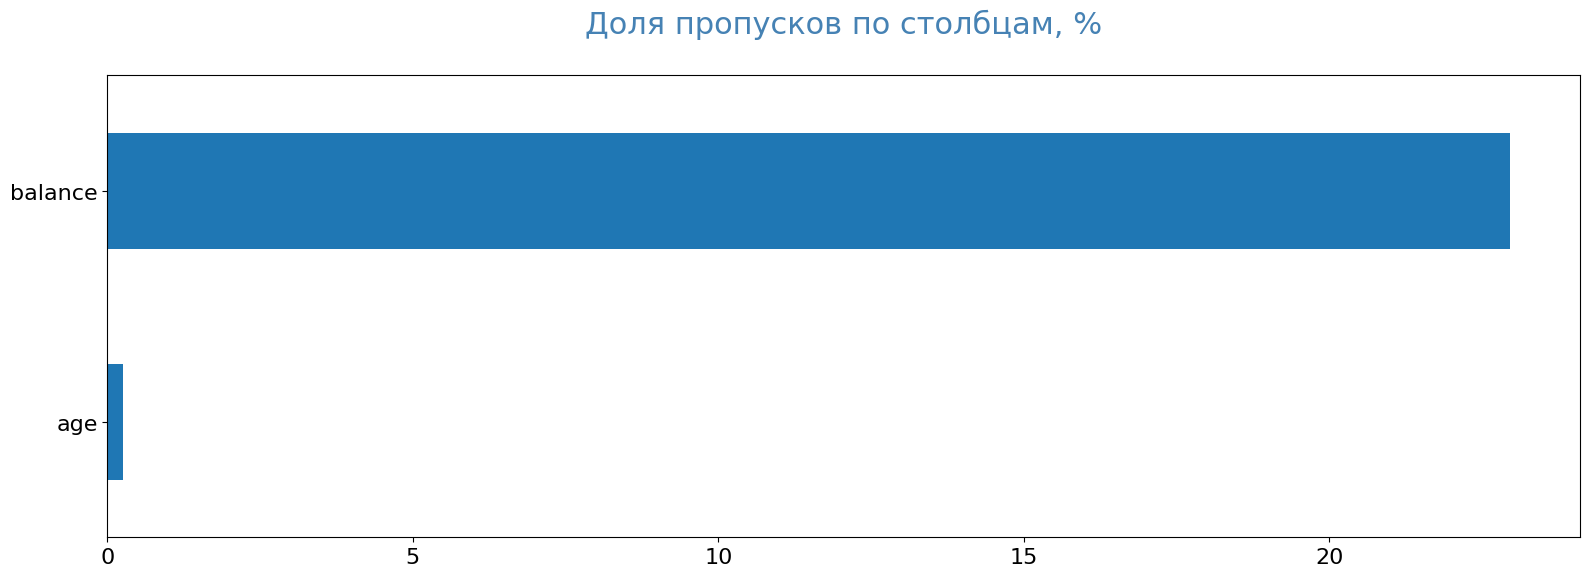

In [6]:
pass_value_barh(df)

Удаляем все пропуски возраста, т.к. таких строк мало:

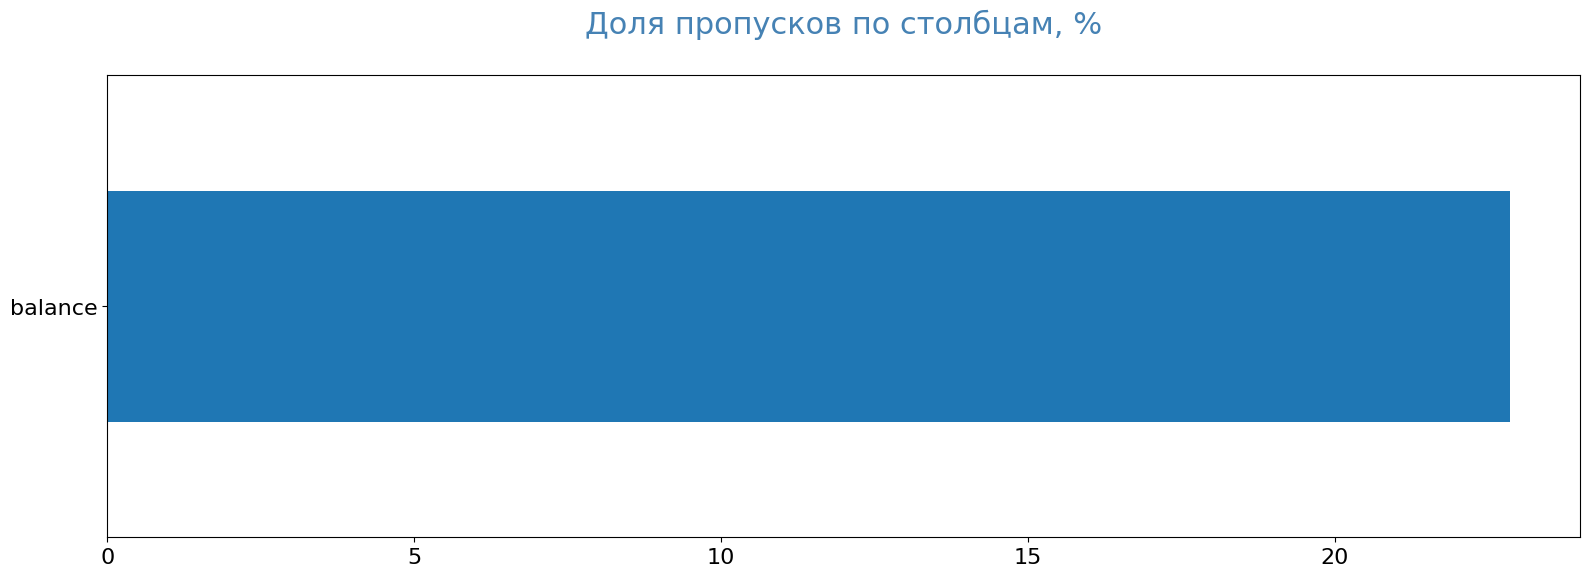

In [7]:
df = df.query('age.isna() == False')
pass_value_barh(df)

- Около четверти записей без значения баланса, проверим связь с другими переменными в базе
- Перед проверкой закодируем категориальные переменные (на случай, если связь с ними)

Проверим наличие неявных дубликатов в категориальных переменных перед кодированием

In [8]:
print(df.city.unique())
df.gender.unique()

['Рыбинск' 'Ярославль' 'Ростов']


array(['Ж', 'М'], dtype=object)

Неявных дубликатов нет, кодируем:

In [9]:
df['gender_male'] = df.gender.apply(lambda x: 1 if x == 'М' else 0)
df['gender_female'] = df.gender.apply(lambda x: 1 if x == 'Ж' else 0)

df['city_rybinsk'] = df.city.apply(lambda x: 1 if x == 'Рыбинск' else 0)
df['city_yaroslavl'] = df.city.apply(lambda x: 1 if x == 'Ярославль' else 0)
df['city_rostov'] = df.city.apply(lambda x: 1 if x == 'Ростов' else 0)

df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_male,gender_female,city_rybinsk,city_yaroslavl,city_rostov
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1,0,1,1,0,0
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0,0,1,1,0,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0,0,1,1,0,0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1,0,1,0,1,0
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1,1,0,0,1,0


Добавим столбец с количеством продуктов у пользователя за вычетом кредитной карты (кредитная карта включена в изначальный столбец)

In [10]:
df['products_wo_credit_card'] = df.products - df.credit_card

Создадим столбец с указателем на наличие пропуска в поле баланса, чтобы рассчитывать корреляцию с ним остальных полей:

In [11]:
df['check_fill_balance'] = df.balance.apply(lambda x: 0 if pd.isnull(x) else 1)
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_male,gender_female,city_rybinsk,city_yaroslavl,city_rostov,products_wo_credit_card,check_fill_balance
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1,0,1,1,0,0,2,1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0,0,1,1,0,0,2,1
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,"107,683.34",0,0,1,1,0,0,0,0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1,0,1,0,1,0,2,1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1,1,0,0,1,0,0,1


Строим таблицу корреляции:

In [12]:
(df[['score','age','equity','balance','products','credit_card','last_activity','est_salary','churn','gender_male',
    'gender_female','city_rybinsk','city_yaroslavl','city_rostov','products_wo_credit_card','check_fill_balance']]
 .corr()['check_fill_balance']
 .sort_values(ascending=False)
 .reset_index())

,index,check_fill_balance
0,check_fill_balance,1.00
1,equity,0.71
2,products,0.49
3,products_wo_credit_card,0.45
4,churn,0.25
5,gender_female,0.06
6,city_rostov,0.06
7,age,0.03
8,city_rybinsk,0.01
9,last_activity,-0.03


Наибольшее влияние у столбцов `equity` `products` `est_salary` и `churn`

Посмотрим на распределение величин этих параметров для заполненного поля баланса (`1`) и для не заполненного (`0`)

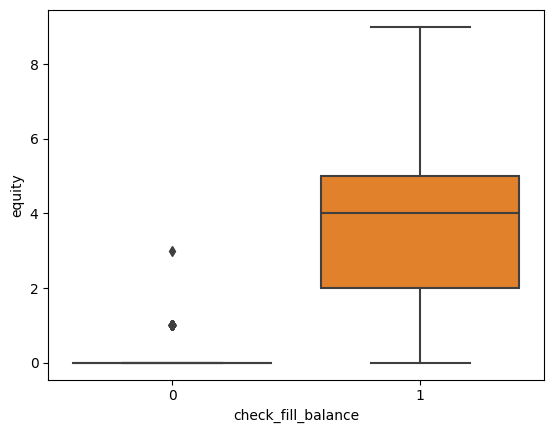

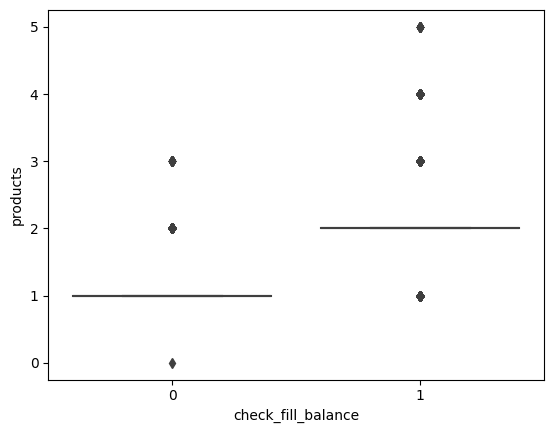

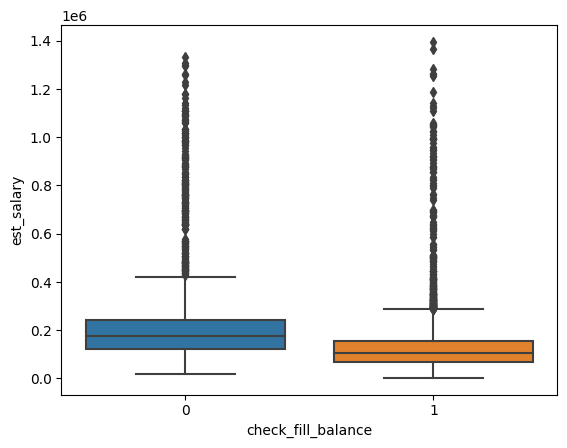

In [13]:
cols = ['equity', 'products', 'est_salary']

for i in cols:
    sns.boxplot(x="check_fill_balance", y=i, data=df);
    plt.show()

- Гипотеза: баланс не проставлен преимущественно у клиентов с нулевым показателем `equity` (но есть несколько выбросов при других значениях), т.е. есть связь с другим показателем из датасета
- Пропуски относятся к виду `missing at random`
- Отбрасывать четверть датасета -- терять большое количество заполненных полей, заполним пропуски 

In [14]:
df.groupby('equity')['check_fill_balance'].mean()

equity
0   0.16
1   0.85
2   1.00
3   1.00
4   1.00
5   1.00
6   1.00
7   1.00
8   1.00
9   1.00
Name: check_fill_balance, dtype: float64

У клиентов с нулем в `equity` заполнено только 16 % строк, с единицей -- только 85 % 

In [15]:
df[df.balance.isna()].equity.unique()

array([0, 1, 3])

Есть пропуски и для `equity` равного трем, сколько их?

In [16]:
df[df.balance.isna()].query('equity == 3')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_male,gender_female,city_rybinsk,city_yaroslavl,city_rostov,products_wo_credit_card,check_fill_balance
8957,147837,962.00,Рыбинск,Ж,79.00,3,NaN,0,0,0,"25,063.96",1,0,1,1,0,0,0,0


Пропуски заполним медианным значением с группировкой по `equity`

In [17]:
print('Медиана баланса при:')
print()
for i in [0, 1, 3]:
    print(f'equity = {i}: {df.query("equity == @i and check_fill_balance == 1")["balance"].median():.0f}')

Медиана баланса при:

equity = 0: 133780
equity = 1: 215786
equity = 3: 463797


- Группировка по `equity` оправдана: медиана баланса для разных значений `equity` существенно отличается
- Заполняем медианными значениями:

In [18]:
for i in [0, 1, 3]:
    median_i = df.query("equity == @i and check_fill_balance == 1")["balance"].median()
    mask_i = df['equity'] == i
    df.loc[mask_i, 'balance'] = df.loc[mask_i, 'balance'].fillna(median_i)

display(df.query('check_fill_balance == 0').head(2))
display(df.query('check_fill_balance == 0 and equity == 1').head(2))
display(df.query('check_fill_balance == 0 and equity == 3').head(2))

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_male,gender_female,city_rybinsk,city_yaroslavl,city_rostov,products_wo_credit_card,check_fill_balance
2,120722,892.00,Рыбинск,Ж,30.00,0,"133,780.07",1,1,1,"107,683.34",0,0,1,1,0,0,0,0
9,133130,906.00,Ярославль,Ж,67.00,0,"133,780.07",1,0,1,"238,055.53",0,0,1,0,1,0,1,0


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_male,gender_female,city_rybinsk,city_yaroslavl,city_rostov,products_wo_credit_card,check_fill_balance
46,118927,921.00,Ярославль,Ж,72.00,1,"215,786.27",1,1,0,"253,494.70",0,0,1,0,1,0,0,0
66,224917,737.00,Ярославль,Ж,54.00,1,"215,786.27",1,1,0,"113,173.05",0,0,1,0,1,0,0,0


,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_male,gender_female,city_rybinsk,city_yaroslavl,city_rostov,products_wo_credit_card,check_fill_balance
8957,147837,962.00,Рыбинск,Ж,79.00,3,"463,796.54",0,0,0,"25,063.96",1,0,1,1,0,0,0,0


Замена корректна, проверим полноту:

пропусков не осталось :) 


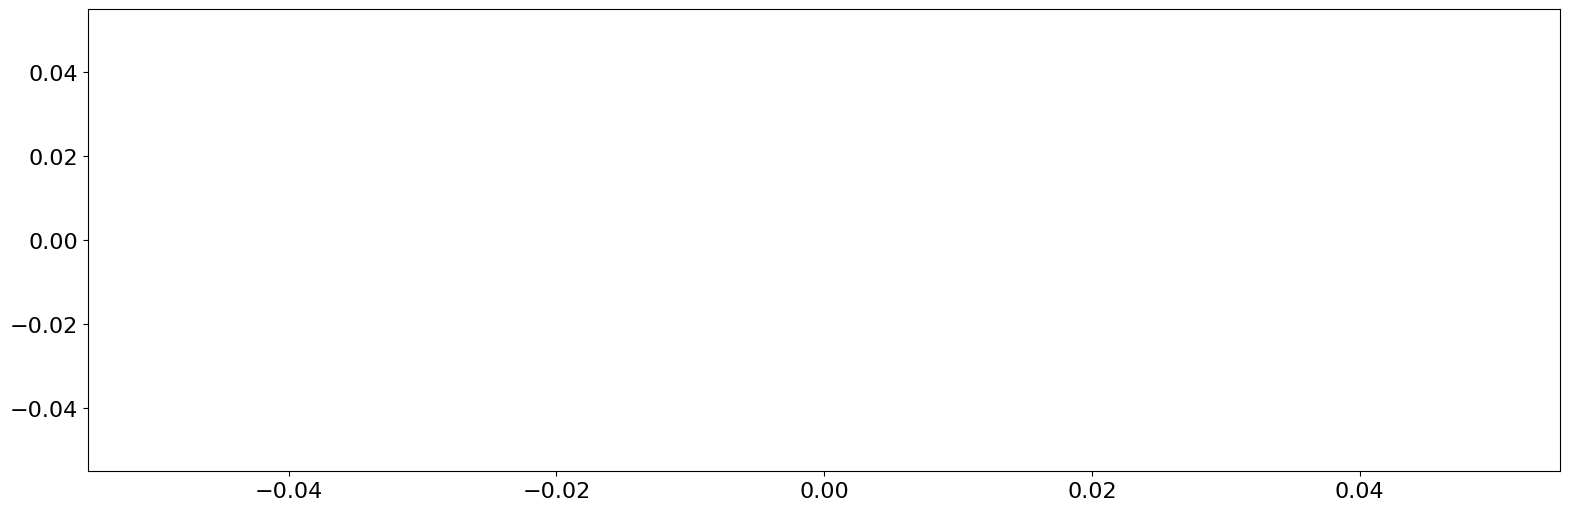

In [19]:
pass_value_barh(df)

Пропуски обработаны

### Преобразование типов

Какого типа столбцы и какие данные в них хранятся?

In [20]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  9974 non-null   int64  
 1   score                    9974 non-null   float64
 2   city                     9974 non-null   object 
 3   gender                   9974 non-null   object 
 4   age                      9974 non-null   float64
 5   equity                   9974 non-null   int64  
 6   balance                  9974 non-null   float64
 7   products                 9974 non-null   int64  
 8   credit_card              9974 non-null   int64  
 9   last_activity            9974 non-null   int64  
 10  est_salary               9974 non-null   float64
 11  churn                    9974 non-null   int64  
 12  gender_male              9974 non-null   int64  
 13  gender_female            9974 non-null   int64  
 14  city_rybinsk            

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_male,gender_female,city_rybinsk,city_yaroslavl,city_rostov,products_wo_credit_card,check_fill_balance
0,183012,850.00,Рыбинск,Ж,25.00,1,"59,214.82",2,0,1,"75,719.14",1,0,1,1,0,0,2,1
1,146556,861.00,Рыбинск,Ж,37.00,5,"850,594.33",3,1,0,"86,621.77",0,0,1,1,0,0,2,1
2,120722,892.00,Рыбинск,Ж,30.00,0,"133,780.07",1,1,1,"107,683.34",0,0,1,1,0,0,0,0
3,225363,866.00,Ярославль,Ж,51.00,5,"1,524,746.26",2,0,1,"174,423.53",1,0,1,0,1,0,2,1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,"67,353.16",1,1,0,0,1,0,0,1


Столбцы `score` и `age` приведем к целочисленному типу:

In [21]:
df[['score', 'age']] = df[['score', 'age']].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  9974 non-null   int64  
 1   score                    9974 non-null   int64  
 2   city                     9974 non-null   object 
 3   gender                   9974 non-null   object 
 4   age                      9974 non-null   int64  
 5   equity                   9974 non-null   int64  
 6   balance                  9974 non-null   float64
 7   products                 9974 non-null   int64  
 8   credit_card              9974 non-null   int64  
 9   last_activity            9974 non-null   int64  
 10  est_salary               9974 non-null   float64
 11  churn                    9974 non-null   int64  
 12  gender_male              9974 non-null   int64  
 13  gender_female            9974 non-null   int64  
 14  city_rybinsk            

### Обработка дубликатов

Отсутствие неявных дубликатов в полях города и пола проверили ранее, проверим наличие явных полных дубликатов:

In [22]:
df.duplicated().sum()

0

Явных полных дубликатов не обнаружено, проверим строки по сочетаниям столбцов:

In [23]:
df.duplicated(subset=['user_id', 'score', 'gender', 'age']).sum()

0

In [24]:
df.duplicated(subset=['score', 'gender', 'age', 'city', 'churn', 'est_salary']).sum()

0

Проверим повторы в `user_id`:

In [25]:
df.duplicated(subset=['user_id']).sum()

50

- Дубликатов малое количество -- удалим их
- Уточним, какое значение из двух с одинаковым `user_id` будем удалять

In [26]:
# copying user_id values to a separate Series 
duplicates = df[df.duplicated(subset=['user_id'])]['user_id']
# showing duplicates/originals
user_id_duplicated_df = df[df.user_id.isin(duplicates)].sort_values(by='user_id')
user_id_duplicated_df.head(20)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_male,gender_female,city_rybinsk,city_yaroslavl,city_rostov,products_wo_credit_card,check_fill_balance
1893,116540,883,Рыбинск,Ж,55,1,"362,756.49",3,0,1,"175,920.48",1,0,1,1,0,0,3,1
7694,116540,887,Ярославль,Ж,38,0,"133,780.07",1,0,1,"119,247.61",0,0,1,0,1,0,1,0
4866,117943,855,Рыбинск,Ж,32,6,"1,036,832.93",4,1,1,"107,792.71",1,0,1,1,0,0,3,1
7542,117943,880,Ярославль,Ж,40,0,"133,780.07",1,1,0,"137,718.93",0,0,1,0,1,0,0,0
5863,120258,908,Рыбинск,Ж,38,4,"2,213,581.63",2,0,1,"160,327.77",1,0,1,1,0,0,2,1
5896,120258,905,Ярославль,М,30,0,"133,780.07",1,1,1,"146,427.96",0,1,0,0,1,0,0,0
1411,123461,829,Ярославль,Ж,59,0,"96,222.44",2,0,1,"102,771.55",1,0,1,0,1,0,2,1
8638,123461,934,Рыбинск,М,34,0,"133,780.07",2,1,0,"291,619.27",0,1,0,1,0,0,1,0
9775,124450,758,Рыбинск,Ж,36,0,"73,574.07",2,0,1,"79,963.59",0,0,1,1,0,0,2,1
8164,124450,859,Ярославль,Ж,38,6,"516,811.20",1,1,1,"95,144.63",1,0,1,0,1,0,0,1


Гипотеза: дублирующиеся пользователи из разных городов, всего два города для сета с дубликатами

In [27]:
user_id_duplicated_df.city.unique()

array(['Рыбинск', 'Ярославль'], dtype=object)

- Действительно, дубли только из этих двух городов
- Рыбинск меньше Ярославля, Ярославль -- административный центр Ярославской области
- Дублирующиеся `user_id`, скорее всего, у разных людей: встречаются отличия в значения пола (возраст и другое можно объяснить проще, чем изменение пола)
- Вероятно, после открытия филиала в Рыбинске, произошла ошибка в процессе присвоения `user_id` -- части пользователей были присвоены такие же идентификаторы, как и пользователям из Ярославля
- Удалим дубли из Рыбинска:

In [28]:
duplicates = user_id_duplicated_df.query('city == "Рыбинск"').index
df = df.drop(index=duplicates)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9924 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  9924 non-null   int64  
 1   score                    9924 non-null   int64  
 2   city                     9924 non-null   object 
 3   gender                   9924 non-null   object 
 4   age                      9924 non-null   int64  
 5   equity                   9924 non-null   int64  
 6   balance                  9924 non-null   float64
 7   products                 9924 non-null   int64  
 8   credit_card              9924 non-null   int64  
 9   last_activity            9924 non-null   int64  
 10  est_salary               9924 non-null   float64
 11  churn                    9924 non-null   int64  
 12  gender_male              9924 non-null   int64  
 13  gender_female            9924 non-null   int64  
 14  city_rybinsk            

Лишних потерь нет, проверим дубликаты в `user_id`:

In [29]:
df.duplicated(subset=['user_id']).sum()

0

Дубликаты ликвидированы

В процессе предобработки отброшено относительно исходного датасета:

In [30]:
lost_rows = 10000 - df.shape[0]

print(f'{lost_rows} строк ({lost_rows / 10000:.1%})')

76 строк (0.8%)


### **Вывод**

- Названия столбцов приведены к змеиному регистру
- Пропуски зафиксированы в двух столбцах: `age` и `balance`
    - Строки с пропуском в `age` отброшены -- они составляли менее 1 % исходного датасета
    - Пропуски в `balance` связаны с величиной параметра `equity`, почти все пропуски при значении `0`, некоторая часть при значении `1`, один пропуск при значении `3`
    - Отсутствующие значения в `balance` составляли более 20 % исходного датасета
    - Пустые значения `balance` заполнены медианным значением с группировкой по `equity`
- Созданы дополнительные столбцы с целью кодирования характеристик `city` и `gender`
- Столбцы `score` и `age` приведены к целочисленному типу
- Обнаружены 50 дубликатов в поле `user_id`
    - Для всех дубликатов характерна картина: один дубль зарегистрирован в Ярославле, второй в Рыбинске
    - Удалены дубликаты из Рыбинска (вероятно появились позднее оригиналов из Ярославля) 
- В результате предобработки отброшено 76 строк исходного датасета (0.8 %) 

## Исследовательский анализ

Рассмотрим распределение клиентов по отточности:

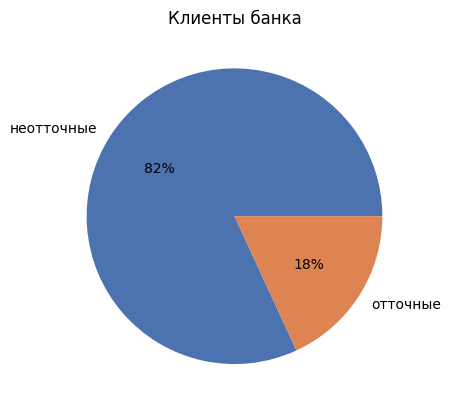

In [31]:
fig, ax = plt.subplots()

colors = sns.color_palette('deep')
ax.pie(df.groupby('churn')['user_id'].count(), labels=['неотточные', 'отточные'], colors=colors, autopct='%1.0f%%')
ax.set(title='Клиенты банка')

plt.show()

Без изменения подхода бизнеса можем ожидать потери пятой части привлеченных клиентов

Подготовим сводную таблицу со сравнением портретов отточного (`churn` = `1`) и неотточного клиента (`churn` = `0`): рассчитаем средние значения всех исходных характеристик с группировкой по `churn`

In [32]:
cols = ['score', 
           'age', 
           'equity', 
           'balance', 
           'products',
           'credit_card', 
           'products_wo_credit_card',
           'last_activity', 
           'est_salary', 
           'gender_male', 
           'gender_female', 
           'city_rybinsk', 
           'city_yaroslavl', 
           'city_rostov']

portraits = df.groupby('churn')[cols].mean().T.rename(columns={0:'неотточный', 1:'отточный'}, 
                                                      index={'score':'баллы скоринга', 
                                                             'age':'возраст', 
                                                             'equity':'баллы собственности', 
                                                             'balance':'текущий баланс', 
                                                             'products':'количество продуктов',
                                                             'products_wo_credit_card':'продуктов без учета кредитки',
                                                             'credit_card':'наличие кредитки', 
                                                             'last_activity':'недавняя активность', 
                                                             'est_salary':'расчетный доход', 
                                                             'gender_male':'мужской пол', 
                                                             'gender_female':'женский пол', 
                                                             'city_rybinsk':'город Рыбинск', 
                                                             'city_yaroslavl':'город Ярославль', 
                                                             'city_rostov':'город Ростов'})

portraits['отклонение'] = (portraits['отточный'] - portraits['неотточный'] ) / portraits['неотточный']
portraits['abs'] = portraits['отклонение'].abs()
portraits = portraits.sort_values(by='abs', ascending=False)
portraits = portraits.drop(columns='abs')
portraits.style.format({'неотточный': '{:.2f}',
                        'отточный': '{:.2f}',
                        'отклонение': '{:.1%}'})

churn,неотточный,отточный,отклонение
текущий баланс,568224.20,1130020.19,98.9%
продуктов без учета кредитки,1.05,1.82,73.8%
баллы собственности,2.38,3.76,58.0%
недавняя активность,0.48,0.70,44.9%
мужской пол,0.47,0.65,39.3%
количество продуктов,1.76,2.38,35.2%
женский пол,0.53,0.35,-34.6%
наличие кредитки,0.71,0.55,-22.1%
город Рыбинск,0.27,0.23,-15.2%
город Ярославль,0.59,0.62,6.1%


**Портрет типичного неотточного клиента**: женщина, баланс около 600 тысяч, пользуется кредитной картой и, в среднем, еще одним продуктом, баллы собственности около 2.4, в последний месяц не было значимых взаимодействий с банком, вероятно, из Рыбинска


**Портрет типичного отточного клиента**: мужчина, баланс около 1.1 млн, не пользуется кредитной картой, пользуется двумя-тремя продуктами, баллы собственности около 3.8, взаимодействовал с банком в последний месяц, вероятно, не из Рыбинска

Влияние показателей города, возраста, баллов скоринга и расчетного дохода необходимо уточнить с помощью статистических критериев: относительное отклонение мало для групп с отточными и неотточными клиентами 

Проверку гипотезы о равенстве долей городов для выборок отточных и неотточных клиентов выполним с помощью z-теста; его применение допустимо, т.к:
- Две выборки независимы друг от друга
- Количество записей в каждой выборке превышает 30, таким образом выборочные доли имеют приближенно нормальный закон распределения

In [33]:
def sample_comparison(city, alpha=0.05): # function for z-test for proportion
    
    target_users = []
    all_users = []
    
    for i in [1, 0]:
        # getting number of users performed an action
        target_users.append(df[df[city] == 1].query('churn == @i')
                            .user_id
                            .nunique())
        # total number of users in group
        all_users.append(df
                         .query('churn == @i')
                         .user_id
                         .nunique())
    
    p_val = proportions_ztest(target_users, all_users, alternative="two-sided")[1]
    
    print('------------------------')
    print(f'Город {city} \n')
    print(f'Доля пользователей из города от всех отточных пользователей: {(target_users[0] / all_users[0]):.1%}')
    print(f'Доля пользователей из города от всех неотточных пользователей: {(target_users[1] / all_users[1]):.1%}')
    print('')
    print(f'H0: Доля пользователей из {city} среди как отточных, так и неотточных пользователей одинаковая')
    print(f'H1: Доля пользователей из {city} для отточных и неотточных пользователей отличается')
    print('')
    print(f'p-value: {p_val:.2%}, alpha: {alpha:.2%}')
    if p_val < alpha:
        print('отвергаем нулевую гипотезу в пользу альтернативной')
    else: print('не удалось отвергнуть нулевую гипотезу')
    print('')
    

In [34]:
for i in ["city_rybinsk", "city_yaroslavl", "city_rostov"]:
    sample_comparison(i)

------------------------
Город city_rybinsk 

Доля пользователей из города от всех отточных пользователей: 23.1%
Доля пользователей из города от всех неотточных пользователей: 27.3%

H0: Доля пользователей из city_rybinsk среди как отточных, так и неотточных пользователей одинаковая
H1: Доля пользователей из city_rybinsk для отточных и неотточных пользователей отличается

p-value: 0.03%, alpha: 5.00%
отвергаем нулевую гипотезу в пользу альтернативной

------------------------
Город city_yaroslavl 

Доля пользователей из города от всех отточных пользователей: 62.1%
Доля пользователей из города от всех неотточных пользователей: 58.6%

H0: Доля пользователей из city_yaroslavl среди как отточных, так и неотточных пользователей одинаковая
H1: Доля пользователей из city_yaroslavl для отточных и неотточных пользователей отличается

p-value: 0.53%, alpha: 5.00%
отвергаем нулевую гипотезу в пользу альтернативной

------------------------
Город city_rostov 

Доля пользователей из города от всех 

- z-тест показал статистически значимое отличие доли пользователей из Рыбинска и Ярославля при рассмотрении отточных и неотточных пользователей
- тестирование не показало статистически значимого отличия в долях отточных и неотточных пользователей из Ростова
- в Рыбинске выше вероятность встретить неотточного пользователя, в Ярославле -- отточного, в Ростове вероятность совпадает

- Для характеристик возраста, баллов скоринга и расчетного дохода проверим гипотезы о равенстве среднего значения характеристики для группы отточных и неотточных пользователей
- Применим критерии Стьюдента и Манна-Уитни

Для применимости критерия Стьюдента должны выполняться следующие условия:
- Независимые выборки
- Распределение выборочных средних нормально относительно среднего совокупности 
    - согласно ЦПТ условие выполняется для выборок большого размера (наш случай)
    - для малых размеров выборок условие выполняется в случае нормального распределения данных в выборке -- необходимо проверять вид распределения перед применением t-теста
- Условие равенства дисперсий генеральных совокупностей (на практике не обязательно -- используются приближения)

In [35]:
numerical_cols = ['score', 'age', 'est_salary'] # list of columns for testing

In [36]:
alpha = .05

# using t-test:
for i in numerical_cols:
    sample_A = df.query('churn == 1')[i]
    sample_B = df.query('churn == 0')[i]
    p_val = st.ttest_ind(sample_A, sample_B, equal_var=False).pvalue
    
    print('------------------------')
    print(i)
    print()
    print(f'H0: среднее значение {i} группы с churn = 1 не отличается от среднего группы с churn = 0')
    print(f'H1: среднее значение {i} группы с churn = 1 отличается от среднего группы с churn = 0')
    print()
    if i == 'est_salary':
        print(f'p-value: {p_val:.2f}, alpha: {alpha:.2f}')
    else:
        print(f'p-value: {p_val:.2e}, alpha: {alpha:.2f}')
    
    print(f'относительное отклонение среднего {i} группы с churn = 1 относительно группы с churn = 0: {(sample_A.mean()/sample_B.mean()-1):.2%}')
    print()
    if p_val < alpha:
        print('отвергаем нулевую гипотезу в пользу альтернативной')
    else: print('не удалось отвергнуть нулевую гипотезу')

------------------------
score

H0: среднее значение score группы с churn = 1 не отличается от среднего группы с churn = 0
H1: среднее значение score группы с churn = 1 отличается от среднего группы с churn = 0

p-value: 4.53e-37, alpha: 0.05
относительное отклонение среднего score группы с churn = 1 относительно группы с churn = 0: 2.12%

отвергаем нулевую гипотезу в пользу альтернативной
------------------------
age

H0: среднее значение age группы с churn = 1 не отличается от среднего группы с churn = 0
H1: среднее значение age группы с churn = 1 отличается от среднего группы с churn = 0

p-value: 2.11e-07, alpha: 0.05
относительное отклонение среднего age группы с churn = 1 относительно группы с churn = 0: -3.60%

отвергаем нулевую гипотезу в пользу альтернативной
------------------------
est_salary

H0: среднее значение est_salary группы с churn = 1 не отличается от среднего группы с churn = 0
H1: среднее значение est_salary группы с churn = 1 отличается от среднего группы с churn

- Критерий Стьюдента показал статистически значимое отличие в средних для баллов скоринга и возраста, но не для расчетного дохода
- Теперь используем критерий Манна-Уитни

Критерий Манна-Уитни обладает меньшей мощностью в сравнении с критерием Стьюдента, но критерий Манна-Уитни непараметрический, а значит не накладывает ограничений на распределение выборочных средних (следовательно и на размер выборок): достаточно условия о независимости выборок друг от друга

In [37]:
# using u-test

for i in numerical_cols:
    sample_A = df.query('churn == 1')[i]
    sample_B = df.query('churn == 0')[i]
    p_val = st.mannwhitneyu(sample_A, sample_B)[1]
    
    print('------------------------')
    print(i)
    print()
    print(f'H0: среднее значение {i} группы с churn = 1 не отличается от среднего группы с churn = 0')
    print(f'H1: среднее значение {i} группы с churn = 1 отличается от среднего группы с churn = 0')
    print()
    print(f'p-value: {p_val:.2e}, alpha: {alpha:.2f}')
    
    print(f'относительное отклонение среднего {i} группы с churn = 1 относительно группы с churn = 0: {(sample_A.mean()/sample_B.mean()-1):.2%}')
    print()
    if p_val < alpha:
        print('отвергаем нулевую гипотезу в пользу альтернативной')
    else: print('не удалось отвергнуть нулевую гипотезу')

------------------------
score

H0: среднее значение score группы с churn = 1 не отличается от среднего группы с churn = 0
H1: среднее значение score группы с churn = 1 отличается от среднего группы с churn = 0

p-value: 9.31e-22, alpha: 0.05
относительное отклонение среднего score группы с churn = 1 относительно группы с churn = 0: 2.12%

отвергаем нулевую гипотезу в пользу альтернативной
------------------------
age

H0: среднее значение age группы с churn = 1 не отличается от среднего группы с churn = 0
H1: среднее значение age группы с churn = 1 отличается от среднего группы с churn = 0

p-value: 6.35e-06, alpha: 0.05
относительное отклонение среднего age группы с churn = 1 относительно группы с churn = 0: -3.60%

отвергаем нулевую гипотезу в пользу альтернативной
------------------------
est_salary

H0: среднее значение est_salary группы с churn = 1 не отличается от среднего группы с churn = 0
H1: среднее значение est_salary группы с churn = 1 отличается от среднего группы с churn

- Результат отличается для показателя расчетного дохода: непараметрический тест требует отвергнуть нулевую гипотезу о равенстве средних, т.е. их отличие статистически значимо
- При условии применимости критерия Стьюдента, его результатам следует доверять больше в силу его большей мощности, т.к. выборки достаточно большие, принимаем результаты критерия Стьюдента

Финализируем портреты:

In [38]:
portraits.style.format({'неотточный': '{:.2f}',
                        'отточный': '{:.2f}',
                        'отклонение': '{:.1%}'})

churn,неотточный,отточный,отклонение
текущий баланс,568224.20,1130020.19,98.9%
продуктов без учета кредитки,1.05,1.82,73.8%
баллы собственности,2.38,3.76,58.0%
недавняя активность,0.48,0.70,44.9%
мужской пол,0.47,0.65,39.3%
количество продуктов,1.76,2.38,35.2%
женский пол,0.53,0.35,-34.6%
наличие кредитки,0.71,0.55,-22.1%
город Рыбинск,0.27,0.23,-15.2%
город Ярославль,0.59,0.62,6.1%


**Портрет типичного неотточного клиента**: женщина, возраст 43 года, баланс около 600 тысяч, пользуется кредитной картой и, в среднем, еще одним продуктом, баллы собственности около 2.4, в последний месяц не было значимых взаимодействий с банком, из Рыбинска, баллы скоринга ~ 845


**Портрет типичного отточного клиента**: мужчина, возраст 41.5 лет, баланс около 1.1 млн, не пользуется кредитной картой, пользуется двумя-тремя продуктами, баллы собственности около 3.8, взаимодействовал с банком в последний месяц, вероятно, из Ярославля, баллы скоринга ~ 863

Рассчитаем коэффициенты корреляции показателя оттока со всеми характеристиками:

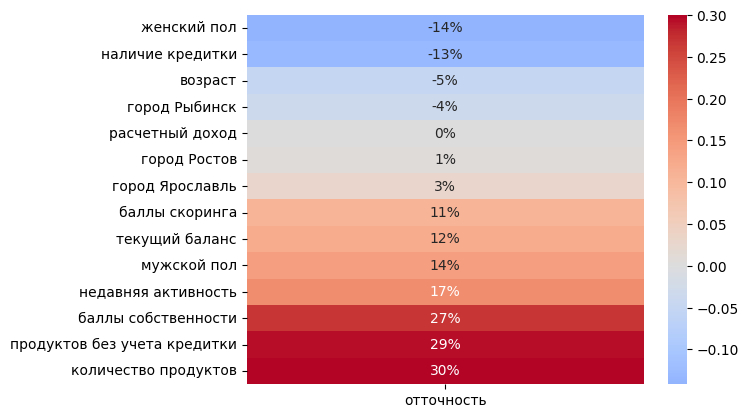

In [39]:
# calculation of correlation coefficient only for numerical values:
numerical_cols = [
                  'score',
                  'age',
                  'equity',
                  'balance',
                  'products',
                  'credit_card',
                  'last_activity',
                  'est_salary',
                  'churn',
                  'gender_male',
                  'gender_female',
                  'city_rybinsk',
                  'city_yaroslavl',
                  'city_rostov',
                  'products_wo_credit_card']

correlation_table = (df[numerical_cols].corr()
                     .loc[:, ['churn']]
                     .drop('churn')
                     .rename(index={'score':'баллы скоринга', 
                                    'age':'возраст', 
                                    'equity':'баллы собственности', 
                                    'balance':'текущий баланс', 
                                    'products':'количество продуктов',
                                    'products_wo_credit_card':'продуктов без учета кредитки',
                                    'credit_card':'наличие кредитки', 
                                    'last_activity':'недавняя активность', 
                                    'est_salary':'расчетный доход', 
                                    'gender_male':'мужской пол', 
                                    'gender_female':'женский пол', 
                                    'city_rybinsk':'город Рыбинск', 
                                    'city_yaroslavl':'город Ярославль', 
                                    'city_rostov':'город Ростов'}, columns={'churn':'отточность'})
                    .sort_values(by='отточность')
                    )

sns.heatmap(correlation_table, annot=True, fmt='.0%', cmap='coolwarm', center=0);

- Для расчетного дохода, города происхождения и возраста клиента отсутствует корреляция с отточностью
- Для показателя количества продуктов прослеживается умеренная положительная корреляция: чем больше количество продуктов, тем выше вероятность отточности клиента
- Оставшиеся показатели демонстрируют слабую корреляцию: 
    - женский пол и наличие кредитки снижают вероятность отточности
    - в порядке увеличения силы корреляции: баллы скоринга, текущий баланс, мужской пол, недавняя активность, баллы собственности, продукты кроме кредитки -- увеличивают вероятность отточности

Для определения интервалов с наибольшей долей неотточных клиентов построим KDE-графики для непрерывных характеристик и гистограммы плотности частоты для ординальных категориальных характеристик

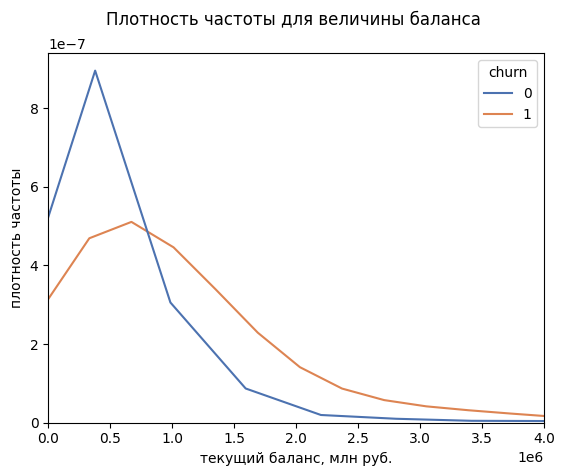

In [40]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='balance', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(0, 4*10**6),
      xlabel='текущий баланс, млн руб.',
      ylabel='плотность частоты',
      title='Плотность частоты для величины баланса \n');

Увелим масштаб для уточнения правой границы

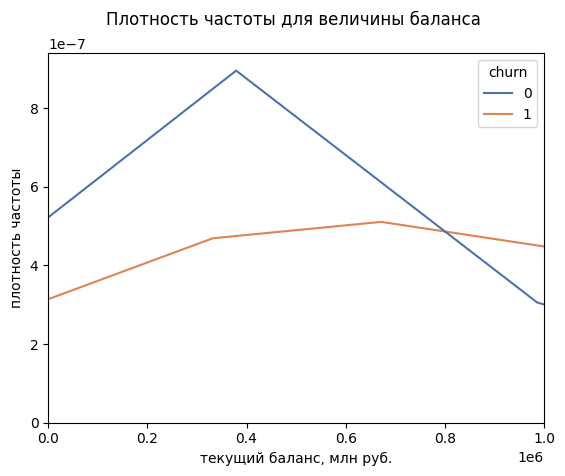

In [41]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='balance', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(0, 1*10**6),
       xlabel='текущий баланс, млн руб.',
       ylabel='плотность частоты',
       title='Плотность частоты для величины баланса \n');

Меньше всего отточных клиентов в интервале текущего баланса от 0 до 800 тысяч

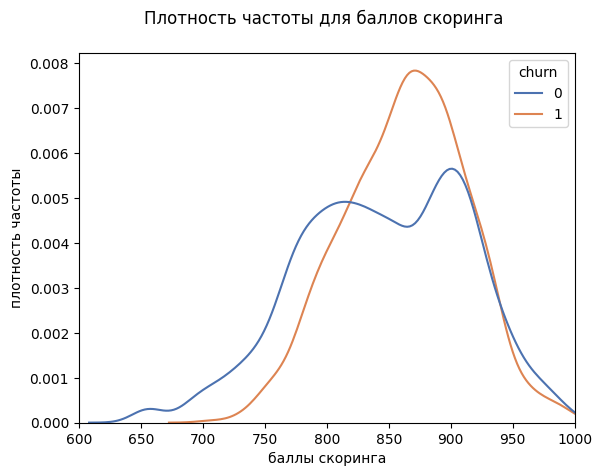

In [42]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='score', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(600, 1000),
      xlabel='баллы скоринга',
      ylabel='плотность частоты',
      title='Плотность частоты для баллов скоринга \n');

Для баллов скоринга два интервала, в которых находятся преимущественно неооточные клиенты: рассмотрим подробнее

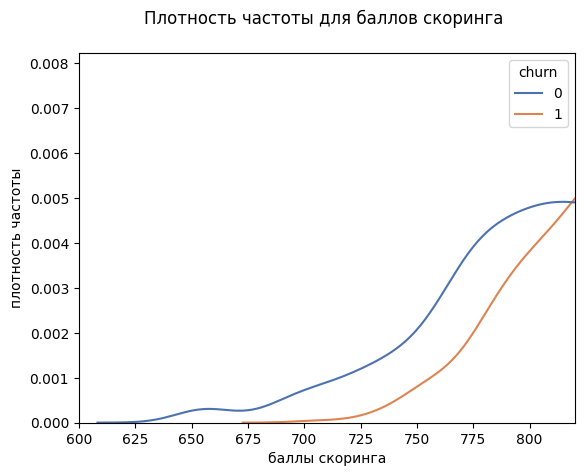

In [43]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='score', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(600, 820),
      xlabel='баллы скоринга',
      ylabel='плотность частоты',
      title='Плотность частоты для баллов скоринга \n');

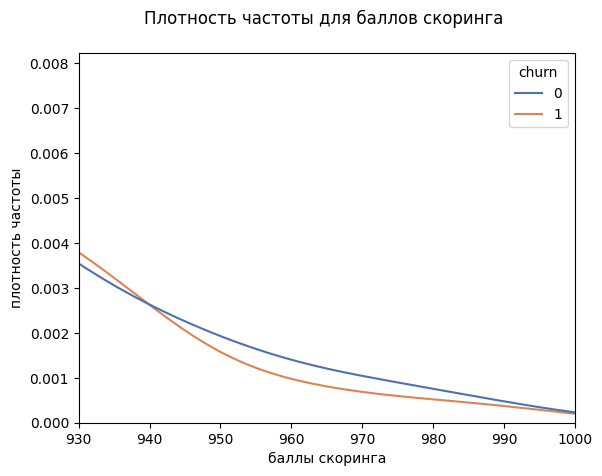

In [44]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='score', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(930, 1000),
      xlabel='баллы скоринга',
      ylabel='плотность частоты',
      title='Плотность частоты для баллов скоринга \n');

Принимаем интервалы от 600 до 820 и от 940 до 1000

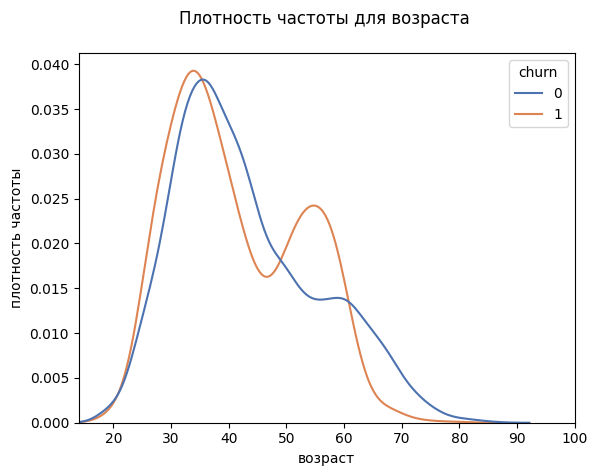

In [45]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='age', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(14, 100),
      xlabel='возраст',
      ylabel='плотность частоты',
      title='Плотность частоты для возраста \n');

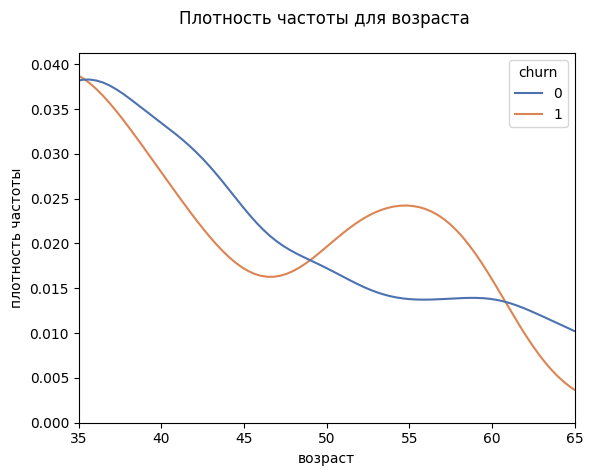

In [46]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='age', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(35, 65),
      xlabel='возраст',
      ylabel='плотность частоты',
      title='Плотность частоты для возраста \n');

Для возраста преимущественно неотточные клиенты находятся в интервалах 36-49 и 61+

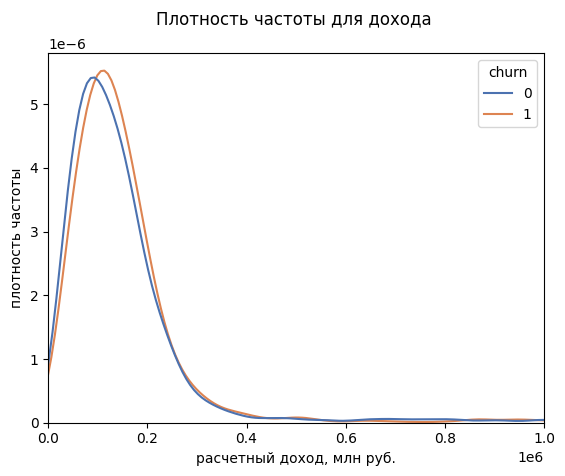

In [47]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='est_salary', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(0, 1*10**6),
      xlabel='расчетный доход, млн руб.',
      ylabel='плотность частоты',
      title='Плотность частоты для дохода \n');

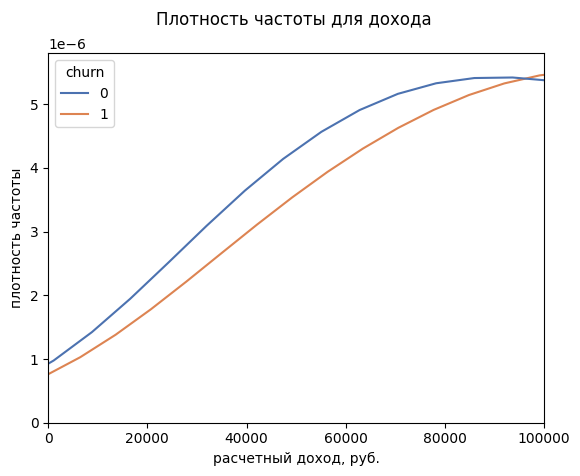

In [48]:
fig, ax = plt.subplots()
sns.kdeplot(ax=ax, data=df, x='est_salary', hue='churn', common_norm=False, palette='deep');
ax.set(xlim=(0, 0.1*10**6),
      xlabel='расчетный доход, руб.',
      ylabel='плотность частоты',
      title='Плотность частоты для дохода \n');

Наиболее неотточная часть клиентов обладает доходом в интервале от 0 до 95 тысяч

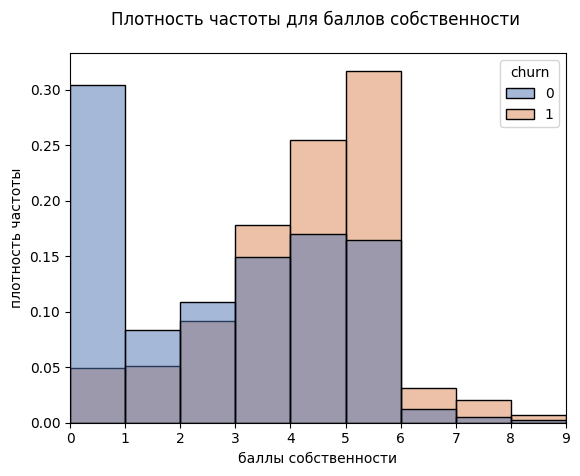

In [49]:
fig, ax = plt.subplots()
sns.histplot(ax=ax, data=df, x='equity', hue='churn', common_norm=False, 
             palette='deep', stat='density', bins=10, binwidth=1);
ax.set(xlim=(0, 9),
      xlabel='баллы собственности',
      ylabel='плотность частоты',
      title='Плотность частоты для баллов собственности \n');

Наиболее неотточные клиенты имеют от нуля до двух баллов собственности включительно

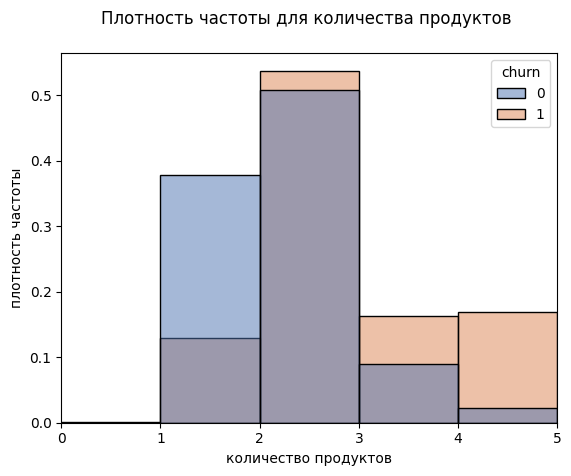

In [50]:
fig, ax = plt.subplots()
sns.histplot(ax=ax, data=df, x='products', hue='churn', common_norm=False, 
             palette='deep', stat='density', bins=6, binwidth=1);
ax.set(xlim=(0, 5),
      xlabel='количество продуктов',
      ylabel='плотность частоты',
      title='Плотность частоты для количества продуктов \n');

У наименее отточных клиентов один продукт в пользовании, посмотрим на гистограмму этого параметра без учета кредитных карт

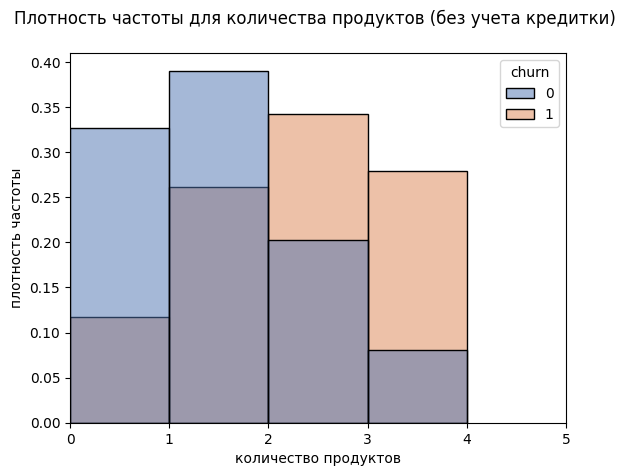

In [51]:
fig, ax = plt.subplots()
sns.histplot(ax=ax, data=df, x='products_wo_credit_card', 
             hue='churn', common_norm=False, palette='deep', stat='density', bins=4);
ax.set(xlim=(0, 5),
      xlabel='количество продуктов',
      ylabel='плотность частоты',
      title='Плотность частоты для количества продуктов (без учета кредитки) \n');

Наиболее неотточная группа клиентов или не пользуется чем-то кроме кредитной карты, или пользуется одним дополнительным продуктом 

Построим гистограммы с уровнями оттока для небинарных характеристик (для слайдов):

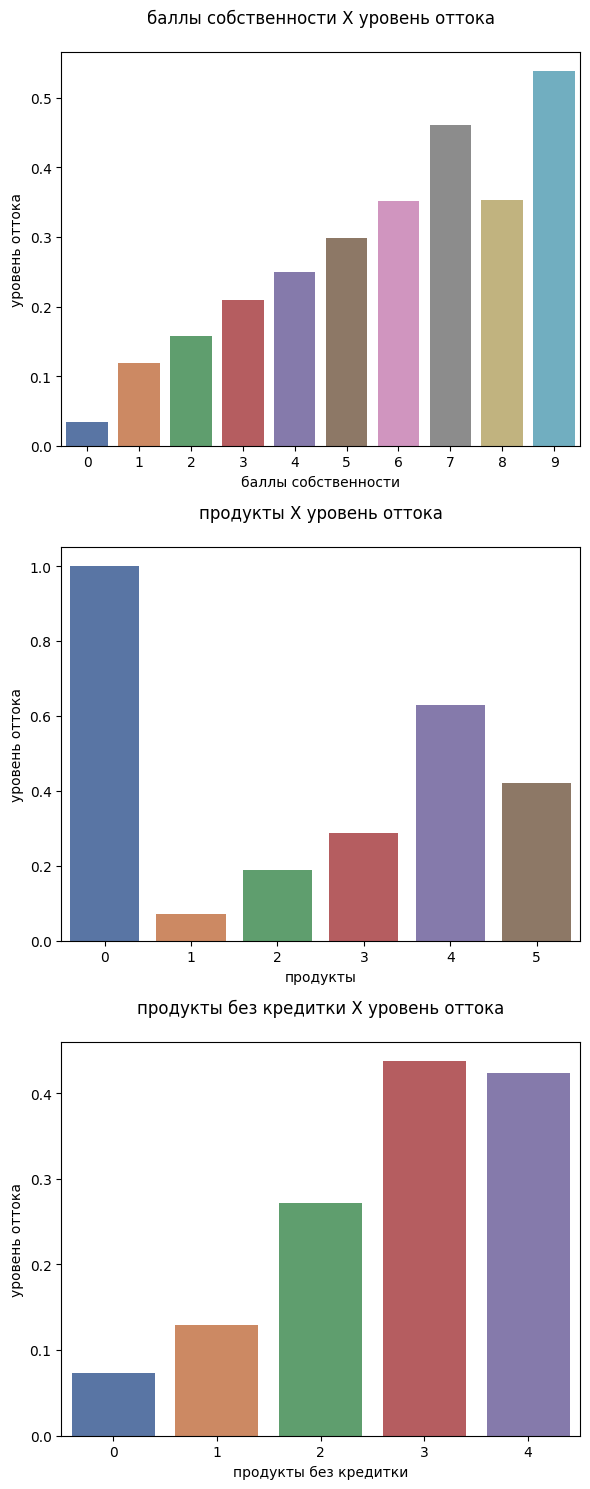

In [52]:
characteristics = { 'equity':'баллы собственности',
                    'products':'продукты',
                    'products_wo_credit_card':'продукты без кредитки'}

fig, ax = plt.subplots(3, 1)
fig.set(size_inches=(6, 15), tight_layout=True)
counter = 0

for i in characteristics.keys():
    mean_churn_vs_char = df.groupby(i)['churn'].mean().reset_index()
    
    sns.barplot(ax=ax[counter], 
                 data=mean_churn_vs_char, 
                 x=mean_churn_vs_char[i], 
                 y=mean_churn_vs_char['churn'],
                 palette='deep'
                 )
    ax[counter].set(xlabel=characteristics[i],
                    ylabel='уровень оттока',
                    title= characteristics[i] + ' X уровень оттока' + '\n');
    counter += 1
    
plt.show()

Соберем все наблюдения в одной таблице

In [53]:
results = (portraits.reset_index()
           .merge(correlation_table.reset_index(), on='index')
           .drop(columns=['неотточный', 'отточный'])
           .rename(columns={'отклонение':'отклонение среднего', 
                            'отточность':'коэф корреляции с оттоком', 
                            'index':'характеристика'})
          )
# calculating complex criteria for characteristics influence estimation
results['критерий'] = results['отклонение среднего'] * results['коэф корреляции с оттоком']
results = results.sort_values(by='критерий', ascending=False).reset_index(drop=True)
results

,характеристика,отклонение среднего,коэф корреляции с оттоком,критерий
0,продуктов без учета кредитки,0.74,0.29,0.22
1,баллы собственности,0.58,0.27,0.16
2,текущий баланс,0.99,0.12,0.12
3,количество продуктов,0.35,0.30,0.11
4,недавняя активность,0.45,0.17,0.08
5,мужской пол,0.39,0.14,0.06
6,женский пол,-0.35,-0.14,0.05
7,наличие кредитки,-0.22,-0.13,0.03
8,город Рыбинск,-0.15,-0.04,0.01
9,баллы скоринга,0.02,0.11,0.00


- Наибольшим влиянием на отточность клиента обладают: продукты в пользовании без кредитной карты, баллы собственности, текущий баланс
- Наименьшим влиянием обладают: расчетный доход, город происхождения, возраст

Добавим в таблицу интервалы / значения характеристик, при которых количество неотточных клиентов максимально:

In [54]:
values = ['0 - 1',
          '0 - 2',
          '0 - 800 000',
          '1',
          '0',
          '0',
          '1',
          '1',
          '1',
          '600 - 820 / 940+',
          '36 - 49 / 61+ ',
          '0',
          '0',
          '0 - 95 000'
         ]

results = results.reset_index(drop=True)
for i in results.index.to_list():
    results.loc[i, 'целевой интервал характеристики'] = values[i]

results

,характеристика,отклонение среднего,коэф корреляции с оттоком,критерий,целевой интервал характеристики
0,продуктов без учета кредитки,0.74,0.29,0.22,0 - 1
1,баллы собственности,0.58,0.27,0.16,0 - 2
2,текущий баланс,0.99,0.12,0.12,0 - 800 000
3,количество продуктов,0.35,0.30,0.11,1
4,недавняя активность,0.45,0.17,0.08,0
5,мужской пол,0.39,0.14,0.06,0
6,женский пол,-0.35,-0.14,0.05,1
7,наличие кредитки,-0.22,-0.13,0.03,1
8,город Рыбинск,-0.15,-0.04,0.01,1
9,баллы скоринга,0.02,0.11,0.00,600 - 820 / 940+


### **Вывод**

- Составлены портреты типичного отточного/неотточного клиента:
    - Неотточный клиент: женщина, возраст 43 года, баланс около 600 тысяч, пользуется кредитной картой и, в среднем, еще одним продуктом, баллы собственности около 2.4, в последний месяц не было значимых взаимодействий с банком, из Рыбинска, баллы скоринга ~ 845, расчетный доход 147.8 тысяч
    - Отточный клиент: мужчина, возраст 41.5 лет, баланс около 1.1 млн, не пользуется кредитной картой, пользуется двумя-тремя продуктами, баллы собственности около 3.8, взаимодействовал с банком в последний месяц, вероятно, из Ярославля, баллы скоринга ~ 863, расчетный доход 148.5 тысяч
- Применены статистические критерии для оценки значимости отличия всех характеристик для групп с отточными и неотточными клиентами
    - Все различия характеристик значимы; исключение составляет город: для жителей Ростова не обнаружено значимого отличия в доле отточных клиентов
- Составлен рейтинг параметров по величине отклонения их значений для отточных и неотточных клиентов
- Рассчитаны коэффициенты корреляции всех параметров с параметром отточности, составлен рейтинг по степени влияния
    - Для расчетного дохода, города происхождения и возраста клиента отсутствует корреляция с отточностью
    - Для показателя количества продуктов прослеживается умеренная положительная корреляция: чем больше количество продуктов, тем выше вероятность отточности клиента
    - Оставшиеся показатели демонстрируют слабую корреляцию:
        - женский пол и наличие кредитки снижают вероятность отточности
        - в порядке увеличения силы корреляции: баллы скоринга, текущий баланс, мужской пол, недавняя активность, баллы собственности, продукты кроме кредитки -- увеличивают вероятность отточности
- Для всех параметров построены KDE-диаграммы и гистограммы плотности частоты, выделены интервалы значений, соответствующие наибольшей доле неотточных клиентов

## Сегментация данных

- Разработаем метрику, характеризующую ценность клиента для банка для ранжирования будущих сегментов
- Показателями, влияющими на потенциальный доход от клиента примем: 
    - используемые продукты
    - баллы собственности
    - текущий баланс
    - активность
    - наличие кредитной карты
    - баллы скоринга
    - расчетный доход
- Считаем, что чем больше показатель, тем лучше, значит направление влияния всех параметров одинаково
- Метрику будем рассчитывать как сумму показателей, приведенных к стобалльной шкале и умноженных на вес показателя:
    - для непрерывных и ординальных категориальных показателей `0` будет соответствовать минимальному значению в датасете, `100` -- максимальному
    - для бинарных показателей `0` = `0`, `1` = `100`
- Максимальный вес в `1.5` присвоим показателям, прямо говорящим о получении дохода от клиента: 
    - используемые продукты
    - наличие кредитной карты
- Средний вес в `1.3` присвоим показателям, характеризующим материальное положение клиента:
    - баллы собственности
    - текущий баланс
    - расчетный доход
- Низкий вес в `1` присвоим оставшимся показателям:
    - активность
    - баллы скоринга

Выведем сводную таблицу с минимальными и максимальными значениями для непрерывных и ординальных категориальных показателей:

In [55]:
for i in ['products_wo_credit_card', 'equity', 'balance', 'score', 'est_salary']:
    print(f'{i}  \n min: {df[i].min()}  max: {df[i].max()} \n')

products_wo_credit_card  
 min: 0  max: 4 

equity  
 min: 0  max: 9 

balance  
 min: 0.0  max: 119113552.01 

score  
 min: 642  max: 1000 

est_salary  
 min: 2546.3  max: 1395064.45 



Рассчитаем метрику для каждого клиента:

In [56]:
scale = 100

df['value'] = (
               1.5 * df.products_wo_credit_card * (scale / df.products_wo_credit_card.max()) +
               1.3 * df.equity * (scale / df.equity.max()) +
               1.3 * df.balance * (scale / df.balance.max()) +
               1 * df.last_activity * scale +
               1.5 * df.credit_card * scale +
               1 * (df.score - df.score.min()) * (scale / df.score.max()) +
               1.3 * (df.est_salary - df.est_salary.min()) * (scale / df.est_salary.max())
              )

- Создадим несколько вложенных циклов, в ходе которых будем делать запросы к исходной таблице
- Один цикл = один показатель
- Параметры следуют в порядке убывания их оценочного влияния на отточность клиентов
- В каждом цикле будем записывать описание запроса, долю отточных клиентов в сегменте и медиану ценности клиентов -- таким образом в таблице будут как короткие запросы из начала алгоритма (с малым количеством фильтров), так и длинные запросы со всеми параметрами в конце
- Значения параметров сфокусированы на целевых значениях из таблицы выше, но также будут выходить за ее пределы, поскольку есть неопределенность в том, какого размера, средней отточности и ценности сегменты будут сформированы
- В итоговых результатах выведем только сегменты, у которых размер от 300 до 2000 человек включительно, а доля отточных клиентов менее 9 % (половина от доли по всему датасету -- 18 %); сортировать результаты будем по ценности сегмента по убыванию

Снова выведем таблицу с показателями

In [57]:
results

,характеристика,отклонение среднего,коэф корреляции с оттоком,критерий,целевой интервал характеристики
0,продуктов без учета кредитки,0.74,0.29,0.22,0 - 1
1,баллы собственности,0.58,0.27,0.16,0 - 2
2,текущий баланс,0.99,0.12,0.12,0 - 800 000
3,количество продуктов,0.35,0.30,0.11,1
4,недавняя активность,0.45,0.17,0.08,0
5,мужской пол,0.39,0.14,0.06,0
6,женский пол,-0.35,-0.14,0.05,1
7,наличие кредитки,-0.22,-0.13,0.03,1
8,город Рыбинск,-0.15,-0.04,0.01,1
9,баллы скоринга,0.02,0.11,0.00,600 - 820 / 940+


In [58]:
pd.set_option('display.max_colwidth', 0) 

In [59]:
segments = pd.DataFrame(
        {'description':[],
        'size':[],
        'churn_rate':[],
         'value_median':[]
       }) 

for prod in [[0], [1], [2], [3], [4]]:
    
    sample = df.query('products_wo_credit_card.isin(@prod)')
    segments.loc[len(segments.index)] = [f'products_wo_cc = {prod}', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]
    
    for equ in [[0], [1], [2], [3], [4]]:
        
        sample = df.query('products_wo_credit_card.isin(@prod)')
        sample = sample.query('equity.isin(@equ)')
        segments.loc[len(segments.index)] = [f'products_wo_cc = {prod} / equity = {equ}', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]
        
        for bal in [ 
                    [0, 200000], 
                    [200000, 400000], 
                    [400000, 600000], 
                    [600000, 800000],
                    [800000, 1000000]]:
            
            sample = df.query('products_wo_credit_card.isin(@prod)')
            sample = sample.query('equity.isin(@equ)')
            sample = sample.query('balance <= @bal[1] and balance >= @bal[0]')
            segments.loc[len(segments.index)] = [f'products_wo_cc = {prod} / equity = {equ} / {bal[0]} <= balance <= {bal[1]}', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]
            for gen in [0, 1]:
                sample = df.query('products_wo_credit_card.isin(@prod)')
                sample = sample.query('equity.isin(@equ)')
                sample = sample.query('balance <= @bal[1] and balance >= @bal[0]')
                sample = sample.query('gender_female == @gen')
                segments.loc[len(segments.index)] = [f'products_wo_cc = {prod} / equity = {equ} / {bal[0]} <= balance <= {bal[1]} / female = {gen}', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]
            
            
                for age in [[18, 35], [36, 45], [46, 54], [55, 70], [71, 90]]:
                    sample = df.query('products_wo_credit_card.isin(@prod)')
                    sample = sample.query('equity.isin(@equ)')
                    sample = sample.query('balance <= @bal[1] and balance >= @bal[0]')
                    sample = sample.query('gender_female == @gen')
                    sample = sample.query('age <= @age[1] and age >= @age[0]')
                    segments.loc[len(segments.index)] = [f'products_wo_cc = {prod} / equity = {equ} / {bal[0]} <= balance <= {bal[1]} / female = {gen} / {age[0]} <= age <= {age[1]}', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]
            
                    for sal in [[0, 75000], [75000, 120000], [120000, 180000], [180000, 400000]]:
                        sample = df.query('products_wo_credit_card.isin(@prod)')
                        sample = sample.query('equity.isin(@equ)')
                        sample = sample.query('balance <= @bal[1] and balance >= @bal[0]')
                        sample = sample.query('gender_female == @gen')
                        sample = sample.query('age <= @age[1] and age >= @age[0]')
                        sample = sample.query('est_salary <= @sal[1] and est_salary >= @sal[0]')    
                        segments.loc[len(segments.index)] = [f'products_wo_cc = {prod} / equity = {equ} / {bal[0]} <= balance <= {bal[1]} / female = {gen} / {age[0]} <= age <= {age[1]} / {sal[0]} <= est_salary <= {sal[1]}', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]     
            
            
                        sample = sample.query('last_activity == 0')
                        segments.loc[len(segments.index)] = [f'products_wo_cc = {prod} / equity = {equ} / {bal[0]} <= balance <= {bal[1]} / female = {gen} / {age[0]} <= age <= {age[1]} / {sal[0]} <= est_salary <= {sal[1]} / last_activity = 0', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]
            
            
            
                        sample = sample.query('credit_card == 1')
                        segments.loc[len(segments.index)] = [f'products_wo_cc = {prod} / equity = {equ} / {bal[0]} <= balance <= {bal[1]} / female = {gen} / {age[0]} <= age <= {age[1]} / {sal[0]} <= est_salary <= {sal[1]} / last_activity = 0 / credit_card', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]

                        sample = sample.query('city_rybinsk == 1')
                        segments.loc[len(segments.index)] = [f'products_wo_cc = {prod} / equity = {equ} / {bal[0]} <= balance <= {bal[1]} / female = {gen} / {age[0]} <= age <= {age[1]} / {sal[0]} <= est_salary <= {sal[1]} / last_activity = 0/ credit_card / city_rybinsk', 
                                         sample.shape[0], sample.churn.mean(), sample.value.median()]
            
            
(segments.query('size >= 300 and size <= 2000 and churn_rate < 0.09')
 .sort_values(by='value_median', 
              ascending=False)
 .head(10)
 .reset_index(drop=True))

,description,size,churn_rate,value_median
0,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 0 / 36 <= age <= 45,307,0.02,279.59
1,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 0,894,0.02,271.75
2,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000,1572,0.01,271.02
3,products_wo_cc = [0] / equity = [0],1608,0.02,270.85
4,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 0 / 18 <= age <= 35,376,0.01,270.02
5,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 1,678,0.01,269.21
6,products_wo_cc = [1] / equity = [0],746,0.03,210.77
7,products_wo_cc = [1] / equity = [0] / 0 <= balance <= 200000 / female = 0,362,0.03,210.77
8,products_wo_cc = [1] / equity = [0] / 0 <= balance <= 200000,706,0.03,208.10
9,products_wo_cc = [1] / equity = [0] / 0 <= balance <= 200000 / female = 1,344,0.03,198.91


In [60]:
print(f'Сформировано {segments.shape[0]} запросов')

Сформировано 21655 запросов


- Для использованных сочетаний параметров и их значений удалось достичь максимальной ценности сегментов в ~270-280 у.е.
- Некоторые сегменты в топе включают другие сегменты, для таргетирования предложения сегменту пользователей удобнее взять максимально детализированные сегменты, обладающие максимальной ценностью
- Для наиболее ценных сегментов характерно:
    - отсутствие продуктов, кроме кредитной карты
    - баллы собственности нулевые
    - текущий баланс до 200 тысяч
- На первом месте сегмент мужчин среднего (36-45 лет) возраста
- На втором месте (при условии выбора самых детализированных сегментов) -- молодые мужчины (18-35 лет)
- На третьем месте женщины без указания на возраст: выбранные в алгоритме значения интервалов возраста не позволили выполнить условия по размеру сегмента, выполним разделение дополнительно:

In [61]:
segments_alt = pd.DataFrame(
        {'description':[],
        'size':[],
        'churn_rate':[],
         'value_median':[]
       })


    
sample_alt = df.query('balance <= 200000 and products_wo_credit_card == 0 and equity == 0 and gender_female == 1 and age <= 39')
    
segments_alt.loc[len(segments_alt.index)] = [f'products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 1 / age <= 39', 
                                         sample_alt.shape[0], sample_alt.churn.mean(), sample_alt.value.median()]

sample_alt = df.query('balance <= 200000 and products_wo_credit_card == 0 and equity == 0 and gender_female == 1 and age >= 43')
    
segments_alt.loc[len(segments_alt.index)] = [f'products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 1 / age >= 43', 
                                         sample_alt.shape[0], sample_alt.churn.mean(), sample_alt.value.median()]



segments_alt.sort_values(by='value_median', ascending=False).head(20).reset_index(drop=True)  

,description,size,churn_rate,value_median
0,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 1 / age <= 39,300,0.00,266.74
1,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 1 / age >= 43,308,0.01,263.35


- Выделены два дополнительных сегмента с разделением сегмента женщин по возрасту
- Соберем итоговые четыре сегмента в одной таблице

In [62]:

top_10_segments = (segments.query('size >= 300 and size <= 2000 and churn_rate < 0.09')
 .sort_values(by='value_median', 
              ascending=False)
 .head(10)
 .reset_index(drop=True))

top_10_segments = top_10_segments.loc[[0, 4],:]

final_segments = pd.concat([top_10_segments, segments_alt], ignore_index = True).reset_index(drop=True)

final_segments.style.format({'size': '{:.0f}',
                        'churn_rate': '{:.2%}',
                        'value_median': '{:.0f}'})

,description,size,churn_rate,value_median
0,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 0 / 36 <= age <= 45,307,1.63%,280
1,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 0 / 18 <= age <= 35,376,1.06%,270
2,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 1 / age <= 39,300,0.00%,267
3,products_wo_cc = [0] / equity = [0] / 0 <= balance <= 200000 / female = 1 / age >= 43,308,1.30%,263


Сформируем предложения для привлечения новых клиентов из этих секторов:

- Сектор мужчин средних лет:
    - дебетовая / кредитная карта с повышенным кешбеком в магазинах категорий "охота и рыбалка" / "все для ремонта" / автозапчасти
    - сервис удобного инвестирования в акции публичных компаний
- Сектор молодых мужчин:
    - дебетовая / кредитная карта с повышенным кешбеком в магазинах компьютерной техники / интернет-магазинах ПК и консольных игр
    - кредит на прохождение образовательных курсов со сниженной процентной ставкой
- Сектор женщин до сорока лет:
    - дебетовая / кредитная карта с повышенным кешбеком в магазинах одежды / косметики / фитнес-центрах
    - кредит для начальных инвестиций в собственный малый бизнес с гибкими условиями
- Сектор женщин после сорока лет:
    - дебетовая / кредитная карта с повышенным кешбеком в аптеках / медицинских центрах
    - сервис "копилка": автоматическое ежемесячное пополнение долгосрочного вклада

### **Вывод**

- Разработана метрика, характеризующая потенциальную ценность клиента для банка
    - Метрика учитывает ряд параметров исходного датасета
    - Параметры приведены к единой шкале
    - Для приоритизации параметров введены веса
- Произведена сегментация клиентской базы с опорой на исследовательский анализ данных
    - Принимались во внимание сила влияния каждого из показателей и целевые интервалы их значений
    - Целевой размер сегмента 300-2000 человек
    - Целевая доля отточных клиентов -- менее 9 %
- Выбраны четыре топовых сегмента:
    - Общие характеристики: нет продуктов кроме кредитки, нулевые баллы собственности, баланс менее 200 тысяч
        1. Мужчины от 36 до 45 лет / 307 человек / 1.63 % отточных / 280 у.е. ценности 
        2. Мужчины от 18 до 35 лет / 376 человек / 1.06 % отточных / 270 у.е. ценности
        3. Женщины моложе 40 лет / 300 человек / нет отточных / 267 у.е. ценности
        4. Женщины старше 42 лет / 308 человек / 1.3 % отточных / 263 у.е. ценности
- Сформированы рекомендации для привлечения новых клиентов из выбранных сегментов:
    - Сектор №1
        - дебетовая / кредитная карта с повышенным кешбеком в магазинах категорий "охота и рыбалка" / "все для ремонта" / автозапчасти
        - сервис удобного инвестирования в акции публичных компаний 
    - Сектор №2
        - дебетовая / кредитная карта с повышенным кешбеком в магазинах компьютерной техники / интернет-магазинах ПК и консольных игр
        - кредит на прохождение образовательных курсов со сниженной процентной ставкой
    - Сектор №3
        - дебетовая / кредитная карта с повышенным кешбеком в магазинах одежды / косметики / фитнес-центрах
        - кредит для начальных инвестиций в собственный малый бизнес с гибкими условиями
    - Сектор №4
        - дебетовая / кредитная карта с повышенным кешбеком в аптеках / медицинских центрах
        - сервис "копилка": автоматическое ежемесячное пополнение долгосрочного вклада
    


## **Общий вывод**

Задача проекта -- разработка рекомендаций для привлечения новых клиентов в банк на основании анализа имеющихся. Была выполнена предобработка данных, исследовательский анализ данных и сегментация клиентской базы. Сегментация позволила выделить топовые сегменты и разработать рекомендации для привлечения. 


**Предобработка**

- Названия столбцов приведены к змеиному регистру
- Пропуски зафиксированы в двух столбцах: `age` и `balance`
    - Строки с пропуском в `age` отброшены -- они составляли менее 1 % исходного датасета
    - Пропуски в `balance` связаны с величиной параметра `equity`, почти все пропуски при значении `0`, некоторая часть при значении `1`, один пропуск при значении `3`
    - Отсутствующие значения в `balance` составляли более 20 % исходного датасета
    - Пустые значения `balance` заполнены медианным значением с группировкой по `equity`
- Созданы дополнительные столбцы с целью кодирования характеристик `city` и `gender`
- Столбцы `score` и `age` приведены к целочисленному типу
- Обнаружены 50 дубликатов в поле `user_id`
    - Для всех дубликатов характерна картина: один дубль зарегистрирован в Ярославле, второй в Рыбинске
    - Удалены дубликаты из Рыбинска (вероятно появились позднее оригиналов из Ярославля) 
- В результате предобработки отброшено 76 строк исходного датасета (0.8 %) 

**Исследовательский анализ**
- Составлены портреты типичного отточного/неотточного клиента:
    - Неотточный клиент: женщина, возраст 43 года, баланс около 600 тысяч, пользуется кредитной картой и, в среднем, еще одним продуктом, баллы собственности около 2.4, в последний месяц не было значимых взаимодействий с банком, из Рыбинска, баллы скоринга ~ 845, расчетный доход 147.8 тысяч
    - Отточный клиент: мужчина, возраст 41.5 лет, баланс около 1.1 млн, не пользуется кредитной картой, пользуется двумя-тремя продуктами, баллы собственности около 3.8, взаимодействовал с банком в последний месяц, вероятно, из Ярославля, баллы скоринга ~ 863, расчетный доход 148.5 тысяч
- Применены статистические критерии для оценки значимости отличия всех характеристик для групп с отточными и неотточными клиентами
    - Все различия характеристик значимы; исключение составляет город: для жителей Ростова не обнаружено значимого отличия в доле отточных клиентов
- Составлен рейтинг параметров по величине отклонения их значений для отточных и неотточных клиентов
- Рассчитаны коэффициенты корреляции всех параметров с параметром отточности, составлен рейтинг по степени влияния
    - Для расчетного дохода, города происхождения и возраста клиента отсутствует корреляция с отточностью
    - Для показателя количества продуктов прослеживается умеренная положительная корреляция: чем больше количество продуктов, тем выше вероятность отточности клиента
    - Оставшиеся показатели демонстрируют слабую корреляцию:
        - женский пол и наличие кредитки снижают вероятность отточности
        - в порядке увеличения силы корреляции: баллы скоринга, текущий баланс, мужской пол, недавняя активность, баллы собственности, продукты кроме кредитки -- увеличивают вероятность отточности
- Для всех параметров построены KDE-диаграммы и гистограммы плотности частоты, выделены интервалы значений, соответствующие наибольшей доле неотточных клиентов



**Сегментация**
- Разработана метрика, характеризующая потенциальную ценность клиента для банка
    - Метрика учитывает ряд параметров исходного датасета
    - Параметры приведены к единой шкале
    - Для приоритизации параметров введены веса
- Произведена сегментация клиентской базы с опорой на исследовательский анализ данных
    - Принимались во внимание сила влияния каждого из показателей и целевые интервалы их значений
    - Целевой размер сегмента 300-2000 человек
    - Целевая доля отточных клиентов -- менее 9 %
- Выбраны четыре топовых сегмента:
    - Общие характеристики: нет продуктов кроме кредитки, нулевые баллы собственности, баланс менее 200 тысяч
        1. Мужчины от 36 до 45 лет / 307 человек / 1.63 % отточных / 280 у.е. ценности 
        2. Мужчины от 18 до 35 лет / 376 человек / 1.06 % отточных / 270 у.е. ценности
        3. Женщины моложе 40 лет / 300 человек / нет отточных / 267 у.е. ценности
        4. Женщины старше 42 лет / 308 человек / 1.3 % отточных / 263 у.е. ценности
- Сформированы рекомендации для привлечения новых клиентов из выбранных сегментов:
    - Сектор №1
        - дебетовая / кредитная карта с повышенным кешбеком в магазинах категорий "охота и рыбалка" / "все для ремонта" / автозапчасти
        - сервис удобного инвестирования в акции публичных компаний 
    - Сектор №2
        - дебетовая / кредитная карта с повышенным кешбеком в магазинах компьютерной техники / интернет-магазинах ПК и консольных игр
        - кредит на прохождение образовательных курсов со сниженной процентной ставкой
    - Сектор №3
        - дебетовая / кредитная карта с повышенным кешбеком в магазинах одежды / косметики / фитнес-центрах
        - кредит для начальных инвестиций в собственный малый бизнес с гибкими условиями
    - Сектор №4
        - дебетовая / кредитная карта с повышенным кешбеком в аптеках / медицинских центрах
        - сервис "копилка": автоматическое ежемесячное пополнение долгосрочного вклада
    

